#Deep Learning on AWS

## Module 3 Demo notebook


In [0]:
# MXNet 설치(Colab만 해당)
# Colab에서 실행할 경우에만 아래 커맨트를 제거하고 실행해 주세요.
# Colab에서 이 코드를 실행할때에는 런타임> 런타임 유형 변경> 런타임 유형: Python 3, 하드웨어 가속기: GPU로 설정해야 합니다.
#!apt install libnvrtc9.1
#!pip uninstall mxnet
#!pip install mxnet-cu92
#!apt-get update -y
#!apt-get install python-pydot -y --allow-unauthenticated

# MXNet의 특징

## 명령형과 선언형 프로그래밍의 차이점


In [4]:
#명령형
import mxnet as mx

x = mx.nd.array([[1, 2, 3], [4, 5, 6]])
y = mx.nd.array([[2, 2, 2], [3, 3, 3]])

z1 = x + y
z2 = x * y

print(z1)
print(z2)


[[3. 4. 5.]
 [7. 8. 9.]]
<NDArray 2x3 @cpu(0)>

[[ 2.  4.  6.]
 [12. 15. 18.]]
<NDArray 2x3 @cpu(0)>


In [0]:
import mxnet as mx
import numpy as np

x = mx.nd.ones(4)
y = np.ones(4)

z = x + mx.nd.array(y)

In [6]:
print(z)


[2. 2. 2. 2.]
<NDArray 4 @cpu(0)>


In [0]:
#선언형
import mxnet as mx
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b

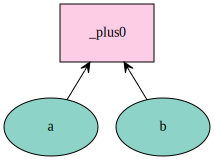

In [8]:
mx.viz.plot_network(symbol=c)

##CPU vs GPU

In [9]:
d = c.bind(mx.cpu(), {'a': mx.nd.array([1,2]), 'b':mx.nd.array([2,3])})
d.forward()

[
 [3. 5.]
 <NDArray 2 @cpu(0)>]

In [10]:
e = c.bind(mx.gpu(), {'a': mx.nd.array([1,2],mx.gpu()), 'b':mx.nd.array([2,3],mx.gpu())})
e.forward()

[
 [3. 5.]
 <NDArray 2 @gpu(0)>]

---
# MXNet의 기본구성

##NDArray

In [11]:
#NDArray
import mxnet as mx

a = mx.nd.array([[1,2],[3,4],[5,6]])
b = mx.nd.ones(100,mx.gpu())

print(a.shape)
print(a.dtype)
print(a.size)
print(a.context)
print(b.context)

(3, 2)
<class 'numpy.float32'>
6
cpu(0)
gpu(0)


In [12]:
{'shape': a.shape, 'dtype': a.dtype}

{'dtype': numpy.float32, 'shape': (3, 2)}

##Symbol

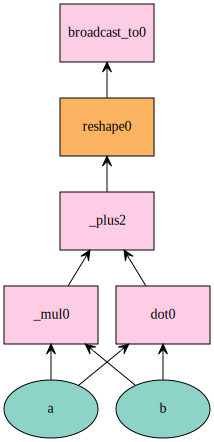

In [13]:
#Symbol
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
d = a * b

e = mx.sym.dot(a, b)

f = mx.sym.reshape(d+e, shape=(1,4))

g = mx.sym.broadcast_to(f, shape=(2,4))

mx.viz.plot_network(symbol=g)

In [14]:
h = g.bind(mx.cpu(), {'a': mx.nd.array([[1,2],[3,4]]), 'b':mx.nd.array([[5,6],[7,8]])})
h.forward()

[
 [[24. 34. 64. 82.]
  [24. 34. 64. 82.]]
 <NDArray 2x4 @cpu(0)>]

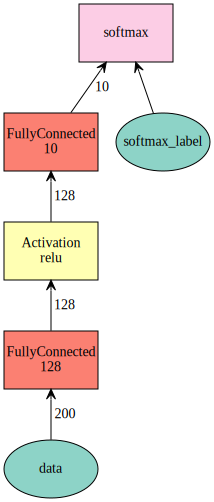

In [15]:
#Symbol NN
import mxnet as mx

net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='softmax')

mx.viz.plot_network(net, shape={'data':(100,200)})

## 트레이닝

In [0]:
mnist = mx.test_utils.get_mnist()
ctx = mx.cpu()

batch_size = 100
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

In [0]:
data = mx.sym.var('data')
data = mx.sym.flatten(data=data)

In [0]:
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

In [0]:
mod.fit(train_iter,
        eval_data=val_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1},
        eval_metric='acc',
        num_epoch=10) 

In [20]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], None, batch_size)
prob = mod.predict(test_iter)
print(prob)


[[5.96126938e-06 4.85885714e-08 1.51155202e-03 ... 9.96776640e-01
  2.13495532e-05 3.70335219e-05]
 [4.63999371e-04 2.76767969e-05 9.96924222e-01 ... 9.33289215e-08
  1.09965149e-04 3.04585440e-10]
 [4.69106089e-06 9.87618327e-01 1.61646178e-03 ... 5.28037408e-03
  2.80901603e-03 6.04013767e-05]
 ...
 [2.46541472e-08 5.78025849e-09 7.80282861e-08 ... 1.74367779e-05
  6.00359868e-04 6.12005882e-04]
 [2.00010181e-05 1.34859665e-05 8.00430712e-07 ... 4.82547250e-07
  7.81987270e-04 2.61588298e-06]
 [6.44117881e-06 2.09386730e-09 6.94579740e-06 ... 1.37149155e-11
  4.45272619e-08 8.22718005e-10]]
<NDArray 10000x10 @cpu(0)>


In [21]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

acc = mx.metric.Accuracy()
mod.score(test_iter, acc)
print(acc)

EvalMetric: {'accuracy': 0.9674}


In [0]:
mod.save_params('myparams')

아래 코드 샘플은 완성된 파라메터를 S3에 업로드 하는 예제입니다.

In [24]:
#학습된 파라메터를 S3 presigned URL에 업로드하기
#%%bash
#curl \
#--request PUT
#--upload-file myparams
#--[파라메터 보관용 S3 presigned URL]

bash: line 1: aws: command not found


##데이터 로드 API

### 화상데이터를 읽어들인 후 변환

In [0]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# Caltech-256 image files
download('http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar')
!tar -xf 256_ObjectCategories.tar

# Tool for creating lst file
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

In [32]:
%%bash

mkdir -p caltech_256_train_60
for i in 256_ObjectCategories/*; do
    c=`basename $i`
    mkdir -p caltech_256_train_60/$c
    for j in `ls $i/*.jpg | shuf | head -n 60`; do
        mv $j caltech_256_train_60/$c/
    done
done

python im2rec.py --list --recursive caltech-256-60-train caltech_256_train_60/
python im2rec.py --list --recursive caltech-256-60-val 256_ObjectCategories/

001.ak47 0
002.american-flag 1
003.backpack 2
004.baseball-bat 3
005.baseball-glove 4
006.basketball-hoop 5
007.bat 6
008.bathtub 7
009.bear 8
010.beer-mug 9
011.billiards 10
012.binoculars 11
013.birdbath 12
014.blimp 13
015.bonsai-101 14
016.boom-box 15
017.bowling-ball 16
018.bowling-pin 17
019.boxing-glove 18
020.brain-101 19
021.breadmaker 20
022.buddha-101 21
023.bulldozer 22
024.butterfly 23
025.cactus 24
026.cake 25
027.calculator 26
028.camel 27
029.cannon 28
030.canoe 29
031.car-tire 30
032.cartman 31
033.cd 32
034.centipede 33
035.cereal-box 34
036.chandelier-101 35
037.chess-board 36
038.chimp 37
039.chopsticks 38
040.cockroach 39
041.coffee-mug 40
042.coffin 41
043.coin 42
044.comet 43
045.computer-keyboard 44
046.computer-monitor 45
047.computer-mouse 46
048.conch 47
049.cormorant 48
050.covered-wagon 49
051.cowboy-hat 50
052.crab-101 51
053.desk-globe 52
054.diamond-ring 53
055.dice 54
056.dog 55
057.dolphin-101 56
058.doorknob 57
059.drinking-straw 58
060.duck 59
061.du

shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error
shuf: write error: Broken pipe
shuf: write error
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe
shuf: write error: Broken pipe


In [33]:
%%bash

python im2rec.py --list --recursive caltech-256-60-train 256_ObjectCategories/

001.ak47 0
002.american-flag 1
003.backpack 2
004.baseball-bat 3
005.baseball-glove 4
006.basketball-hoop 5
007.bat 6
008.bathtub 7
009.bear 8
010.beer-mug 9
011.billiards 10
012.binoculars 11
013.birdbath 12
014.blimp 13
015.bonsai-101 14
016.boom-box 15
017.bowling-ball 16
018.bowling-pin 17
019.boxing-glove 18
020.brain-101 19
021.breadmaker 20
022.buddha-101 21
023.bulldozer 22
024.butterfly 23
025.cactus 24
026.cake 25
027.calculator 26
028.camel 27
029.cannon 28
030.canoe 29
031.car-tire 30
032.cartman 31
033.cd 32
034.centipede 33
035.cereal-box 34
036.chandelier-101 35
037.chess-board 36
038.chimp 37
039.chopsticks 38
040.cockroach 39
041.coffee-mug 40
042.coffin 41
043.coin 42
044.comet 43
045.computer-keyboard 44
046.computer-monitor 45
047.computer-mouse 46
048.conch 47
049.cormorant 48
050.covered-wagon 49
051.cowboy-hat 50
052.crab-101 51
053.desk-globe 52
054.diamond-ring 53
055.dice 54
056.dog 55
057.dolphin-101 56
058.doorknob 57
059.drinking-straw 58
060.duck 59
061.du

In [34]:
%%bash

python im2rec.py caltech-256-60-train 256_ObjectCategories/

Creating .rec file from /content/caltech-256-60-train.lst in /content
multiprocessing not available, fall back to single threaded encoding
time: 0.005728483200073242  count: 0
time: 4.430431365966797  count: 1000
time: 3.3001928329467773  count: 2000
time: 4.156344890594482  count: 3000
time: 3.9114584922790527  count: 4000
time: 3.697641134262085  count: 5000
time: 3.3139681816101074  count: 6000
time: 3.575165271759033  count: 7000
time: 3.7848734855651855  count: 8000
time: 3.7493038177490234  count: 9000
time: 3.6745266914367676  count: 10000
time: 3.846400499343872  count: 11000
time: 3.8277361392974854  count: 12000
time: 5.222974061965942  count: 13000
time: 4.614369630813599  count: 14000
time: 4.282680988311768  count: 15000


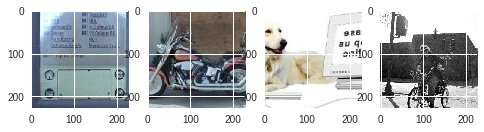

In [35]:
#이미지 데이터 로드
import os
import subprocess
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt

data_iter = mx.io.ImageRecordIter(
    path_imgrec="./caltech-256-60-train.rec",
    data_shape=(3, 227, 227),
    batch_size=4,
    resize=256
    )
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

---
#Convolutional Neural Networks 

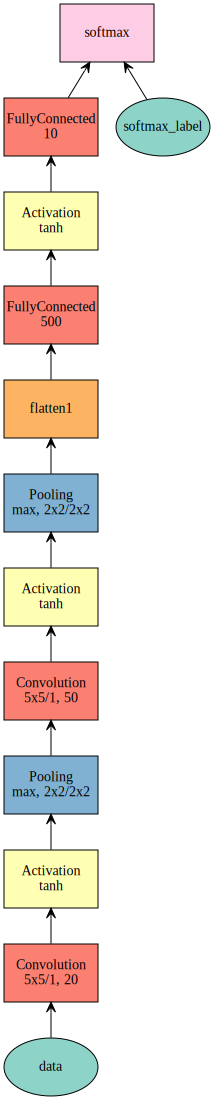

In [26]:
#LeNet
import mxnet as mx

data = mx.symbol.Variable('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))

flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")

fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)

lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

mx.viz.plot_network(symbol=lenet)

---
##Gluon

In [0]:
import mxnet as mx
from mxnet import gluon, autograd, ndarray

In [0]:
data = mx.test_utils.get_mnist()

train_data = data['train_data'].reshape((-1, 784))
train_label = data['train_label']
test_data = data['test_data'].reshape((-1, 784))
test_label = data['test_label']

train_data_mx = mx.nd.array(train_data)
train_label_mx = mx.nd.array(train_label)
test_data_mx = mx.nd.array(test_data)
test_label_mx = mx.nd.array(test_label)

In [0]:
batch_size = 32
train_data = mx.io.NDArrayIter(train_data_mx, train_label_mx, batch_size,shuffle=True) 

In [0]:
net = gluon.nn.Sequential()

with net.name_scope():
    net.add(gluon.nn.Dense(128, activation="relu"))
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dense(10))

In [31]:
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym)
data

{'test_data': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0.,

In [0]:
net.collect_params().initialize(mx.init.Normal(sigma=0.05))
#net.collect_params().initialize(mx.init.Normal(sigma=0.05), force_reinit=True)

In [0]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

In [0]:
#학습
train_data.reset()
epochs = 10

for e in range(epochs):
    for i, batch in enumerate(train_data):
        data = batch.data[0]
        label = batch.label[0]

        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            loss.backward()
        trainer.step(data.shape[0])

In [35]:
#모델의 평가
acc = mx.metric.Accuracy()
output = net(test_data_mx)
predictions = ndarray.argmax(output, axis=1)
acc.update(preds=predictions, labels=test_label_mx) 
print(acc)

EvalMetric: {'accuracy': 0.951}


In [36]:
#파라메터를 저장
net.save_params('mod3-demo')

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:345: UserWarning: save_params is deprecated. Please use save_parameters. Note that if you want load from SymbolBlock later, please use export instead. For details, see https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
  warnings.warn("save_params is deprecated. Please use save_parameters. "


In [37]:
#저장된 파라메터를 읽어들임
net2 = gluon.nn.Sequential()
with net2.name_scope():
    net2.add(gluon.nn.Dense(128, activation="relu")) 
    net2.add(gluon.nn.Dense(64, activation="relu"))
    net2.add(gluon.nn.Dense(10))

net2.load_params('mod3-demo',ctx=mx.cpu())

acc2 = mx.metric.Accuracy()
output = net2(test_data_mx)
predictions = ndarray.argmax(output, axis=1) 
acc2.update(preds=predictions, labels=test_label_mx)
print(acc2)

EvalMetric: {'accuracy': 0.951}


/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:421: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


##Hybridblock

In [0]:
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn

mx.random.seed(42)

class Net(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            self.conv1 = nn.Conv2D(6, kernel_size=5)
            self.pool1 = nn.MaxPool2D(pool_size=2)
            self.conv2 = nn.Conv2D(16, kernel_size=5)
            self.pool2 = nn.MaxPool2D(pool_size=2)
            self.fc1 = nn.Dense(120)
            self.fc2 = nn.Dense(84)

            self.fc3_weight = self.params.get('fc3_weight', shape=(10, 84))

    def hybrid_forward(self, F, x, fc3_weight):
        print('hybrid forward')
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.reshape((0, -1))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dot(x, fc3_weight, transpose_b=True)
        return x

In [39]:
net = Net()
net.initialize()
x = mx.nd.random_normal(shape=(16, 1, 28, 28))
print(len(net(x)))
x = mx.nd.random_normal(shape=(16, 1, 28, 28))
print(len(net(x)))

hybrid forward
16
hybrid forward
16


In [40]:
#캐시를 사용함
net.hybridize()
x = mx.nd.random_normal(shape=(16, 1, 28, 28))
print(len(net(x)))
x = mx.nd.random_normal(shape=(16, 1, 28, 28))
print(len(net(x)))

hybrid forward
16
16
